In [1]:
#Importing libraries
import os
import re
import logging
import pandas as pd
import numpy as np
import nltk.data
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
from sklearn import naive_bayes, svm, preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection.univariate_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
import scikitplot as skplt
import matplotlib.pyplot as plt

C:\Users\shruti\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used
C:\Users\shruti\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\shruti\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\shru

In [7]:
#Pre-processing movie reviews
def clean_review(raw_review):
    # Remove HTML markup
    text = BeautifulSoup(raw_review, "lxml")
    
    #Removing digits and punctuation
    text = re.sub("[^a-zA-Z]", " ", text.get_text())
    
    #Converting to lowercase
    text = text.lower().split()
    
    # Removing stopwords
    stops = set(stopwords.words("english"))
    words = [w for w in text if w not in stops]
    
    # Return a cleaned string
    return " ".join(words)

In [8]:
#Generates a feature vector(word2vec averaging) for each movie review
def review_to_vec(words, model, num_features):
    """
    This function generates a feature vector for the given review.
    Input:
        words: a list of words extracted from a review
        model: trained word2vec model
        num_features: dimension of word2vec vectors
    Output:
        a numpy array representing the review
    """
    
    feature_vec = np.zeros((num_features), dtype="float32")
    word_count = 0
    
    # index2word_set is a set consisting of all words in the vocabulary
    index2word_set = set(model.index2word)
    
    for word in words:
        if word in index2word_set: 
            word_count += 1
            feature_vec += model[word]

    feature_vec /= word_count
    return feature_vec
    

In [9]:
#Generates vectorized movie reviews
def gen_review_vecs(reviews, model, num_features):
    """
    Function which generates a m-by-n numpy array from all reviews,
    where m is len(reviews), and n is num_feature
    Input:
            reviews: a list of lists. 
                     Inner lists are words from each review.
                     Outer lists consist of all reviews
            model: trained word2vec model
            num_feature: dimension of word2vec vectors
    Output: m-by-n numpy array, where m is len(review) and n is num_feature
    """

    curr_index = 0
    review_feature_vecs = np.zeros((len(reviews), num_features), dtype="float32")

    for review in reviews:

       if curr_index%1000 == 0.:
           print ("Vectorizing review %d of %d" % (curr_index, len(reviews)))
   
       review_feature_vecs[curr_index] = review_to_vec(review, model, num_features)
       curr_index += 1
       
    return review_feature_vecs

In [10]:
#TFIDF vectorization
def tfidf_vectorizer(train_list,test_list,train_data,test_data):
    for i in range(0, len(train_data.review)):
        
        # Append raw texts as TFIDF vectorizers take raw texts as inputs
        train_list.append(clean_review(train_data.review[i]))
        if i%1000 == 0:
            print ("Cleaning training review", i)

    for i in range(0, len(test_data.review)):
        
        # Append raw texts as TFIDF vectorizers take raw texts as inputs
        test_list.append(clean_review(test_data.review[i]))
        if i%1000 == 0:
            print ("Cleaning test review", i)
    count_vec = TfidfVectorizer(analyzer="word", max_features=10000, ngram_range=(1,2), sublinear_tf=True)
    print ("Vectorizing input texts")
    train_vec = count_vec.fit_transform(train_list)
    test_vec = count_vec.transform(test_list)
    return train_vec,test_vec,count_vec

In [11]:
#Performing dimensionality reduction using SelectKBest
def dimensionality_reduction(train_vec,test_vec,y_train_data):
    print ("Performing feature selection based on chi2 independence test")
    fselect = SelectKBest(chi2,k=500)
    train_vec = fselect.fit_transform(train_vec, y_train_data)
    test_vec = fselect.transform(test_vec)
    return train_vec,test_vec

In [12]:
#Naive Bayes classifier
def naive_bayes(train_vec,test_vec,y_train_data):
    nb = MultinomialNB()
    cv_score = cross_val_score(nb, train_vec,y_train_data, cv=10)
    print("Training Naive Bayes")
    nb = nb.fit(train_vec,y_train_data)
    pred_naive_bayes = nb.predict(test_vec)
    print ("CV Score = ", cv_score.mean())
    predictions = cross_val_predict(nb, train_vec, y_train_data)
    skplt.metrics.plot_confusion_matrix(y_train_data, predictions)
    plt.show()
    #result = nb.predict_proba(train_vec)
    skplt.metrics.plot_precision_recall_curve(y_train_data, predictions)
    plt.show()
    return pred_naive_bayes
    

In [13]:
#Random Forest classifier
def random_forest(train_vec,test_vec,y_train_data):
    rfc = RFC(n_estimators = 100,oob_score = True,max_features ="auto")
    print("Training %s" % ("Random Forest"))
    rfc = rfc.fit(train_vec,y_train_data)
    print("OOB Score =", rfc.oob_score_)
    pred_random_forest = rfc.predict(test_vec)
    return pred_random_forest

In [14]:
#Linear SVM classifier
def linear_svm(train_vec,test_vec,y_train_data):  
    svc = svm.LinearSVC()
    param = {'C': [1e15,1e13,1e11,1e9,1e7,1e5,1e3,1e1,1e-1,1e-3,1e-5]}
    print ("Training SVM")
    svc = GridSearchCV(svc, param,cv=10)
    svc = svc.fit(train_vec, y_train_data)
    pred_linear_svm = svc.predict(test_vec)
    print ("Optimized parameters:", svc.best_estimator_)
    print ("Best CV score:", svc.best_score_)
    return pred_linear_svm

In [15]:
#Using Logistic Regression
def logistic_regression(train_vec,test_vec,y_train_data):
    clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
    cv_score = cross_val_score(clf, train_vec,y_train_data, cv=10)
    print("Training Logistic Regression")
    clf = clf.fit(train_vec,y_train_data)
    pred_logistic= clf.predict(test_vec)
    print ("CV Score = ", cv_score.mean())
    return pred_logistic

In [16]:
#Word2Vec vectorization
def word2vec(train_data,test_data,train_list,test_list):
    model_name = "C:\\Users\\shruti\\sentiment.analysis\\GoogleNews-vectors-negative300.bin.gz"
    model_type = "bin"
    num_features = 300
    for i in range(0, len(train_data.review)):
        train_list.append(clean_review(train_data.review[i]))
        if i%1000 == 0:
            print("Cleaning training review",i)
    for i in range(0, len(test_data.review)):
        test_list.append(clean_review(test_data.review[i]))
        if i%1000 == 0:
            print ("Cleaning test review", i)
    print ("Loading the pre-trained model")
    #The below part has been commented as the model was loaded, movie reviews were vectorized and stored in below pkl files, 
    #as this takes a lot of time to execute. 
    #We are reading the pkl files to get the final vectorized data
    
    #model = Word2Vec.load_word2vec_format(model_name, binary=True)
    print ("Vectorizing training review")
    #train_vec = gen_review_vecs(train_list, model, num_features)
    #print ("Vectorizing test review")
    #test_vec = gen_review_vecs(test_list, model, num_features)
    
    #print("Writing to DataFrame after vectorizing")
    #df_train = pd.DataFrame(train_vec)
    #df_test = pd.DataFrame(test_vec)
    #df_train.to_pickle("C:\\Users\\shruti\\sentiment.analysis\\train.pkl")
    #df_test.to_pickle("C:\\Users\\shruti\\sentiment.analysis\\test.pkl")
    
    
    y_train_data = train_data.sentiment
    train_df= pd.read_pickle("C:\\Users\\shruti\\sentiment.analysis\\train.pkl")
    test_df = pd.read_pickle("C:\\Users\\shruti\\sentiment.analysis\\test.pkl")
    
    #Word2Vec cannot be used with Naive Bayes as Naive Bayes does not work with negative values 
    pred_logistic = logistic_regression(train_df,test_df,y_train_data)
    pred_random_forest = random_forest(train_df,test_df,y_train_data)
    pred_linear_svm = linear_svm(train_df,test_df,y_train_data)
    
    output = pd.DataFrame(data = {"id": test_data.id,"review":test_data.review, "sentiment": pred_linear_svm})
    output.to_csv("C:\\Users\\shruti\\sentiment.analysis\\word2vec.csv", index=False)

In [17]:
#Testing a custom movie review
def test_custom_review(count_vec,train_vec,y_train_data):
    print('\nTest a custom review message')
    print('Enter review to be analysed: ',end=" ")

    test = []
    test_list = []
    test.append(input())
    test_review= pd.DataFrame(data = {"id": 1, "review": test})
    print("Cleaning the test review")
    for i in range(0, len(test_review.review)):
        test_list.append(clean_review(test_review.review[i]))
    print("Vectorizing the test review")
    test_review_vec = count_vec.transform(test_list)
    print("Predicting")
    #pred_logistic= logistic_regression(train_vec,test_review_vec,y_train_data)
    clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
    print("Training Logistic Regression")
    clf = clf.fit(train_vec,y_train_data)
    pred_logistic= clf.predict(test_review_vec)
    
    if(pred_logistic == 1):
        print("The review is predicted positive")
    else:
        print("The review is predicted negative")
    
    

Using TFIDF 
Cleaning training review 0
Cleaning training review 1000
Cleaning training review 2000
Cleaning training review 3000
Cleaning training review 4000
Cleaning training review 5000
Cleaning training review 6000
Cleaning training review 7000
Cleaning training review 8000
Cleaning training review 9000
Cleaning training review 10000
Cleaning training review 11000
Cleaning training review 12000
Cleaning training review 13000
Cleaning training review 14000
Cleaning training review 15000
Cleaning training review 16000
Cleaning training review 17000
Cleaning training review 18000
Cleaning training review 19000
Cleaning training review 20000
Cleaning training review 21000
Cleaning training review 22000
Cleaning training review 23000
Cleaning training review 24000
Cleaning test review 0
Cleaning test review 1000
Cleaning test review 2000
Cleaning test review 3000
Cleaning test review 4000
Cleaning test review 5000
Cleaning test review 6000
Cleaning test review 7000
Cleaning test review

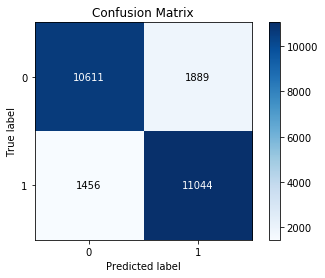

C:\Users\shruti\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


IndexError: too many indices for array

In [18]:
if __name__ == "__main__":
    train_list = []
    test_list = []
    word2vec_input = []
    
    pred_naive_bayes = []
    pred_logistic = []
    pred_random_forest = []
    pred_linear_svm = []
    train_data = pd.read_csv("C:\\Users\\shruti\\sentiment.analysis\\labeledTrainData.tsv",header=0, delimiter="\t", quoting=0)
    test_data = pd.read_csv("C:\\Users\\shruti\\sentiment.analysis\\testData.tsv",header=0, delimiter="\t", quoting=0)
    
    y_train_data = train_data.sentiment
    
    #Vectorization - TFIDF
    print("Using TFIDF ")
    train_vect,test_vec,count_vec= tfidf_vectorizer(train_list,test_list,train_data,test_data)
    
    #Dimensionality Reduction
    train_vec,test_vec = dimensionality_reduction(train_vect,test_vec,y_train_data)
    
    #Prediction 
    pred_naive_bayes = naive_bayes(train_vec,test_vec,y_train_data)
    #pred_random_forest = random_forest(train_vec,test_vec,y_train_data)
    #pred_linear_svm = linear_svm(train_vec,test_vec,y_train_data)
    #pred_logistic = logistic_regression(train_vec,test_vec,y_train_data)      
    
    #output = pd.DataFrame(data = {"id": test_data.id,"review":test_data.review, "sentiment": pred_linear_svm})
    #output.to_csv("C:\\Users\\shruti\\sentiment.analysis\\tfidf_svm.csv", index=False)
    
    print("Using pre-trained word2vec model")
    train_list = []
    test_list = []
    pred_logistic = []
    pred_random_forest = []
    pred_linear_svm = []
    
    word2vec(train_data,test_data,train_list,test_list)
    
    #Test a custom review using Logistic Regression
    test_custom_review(count_vec,train_vect,y_train_data)
    
    
    